In [0]:

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import tensorflow as tf
import nltk, re, time
from nltk.corpus import stopwords
from string import punctuation
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from collections import namedtuple

Using TensorFlow backend.


In [0]:
import string
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings('ignore')

In [0]:

# using the SQLite Table to read data.
con = sqlite3.connect('drive/My Drive/amazon/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Preprocessing 

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
final['Text']=final['Text'].str.lower()

In [0]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","i grew up reading these sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,this is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,this is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,this is a book of poetry about the months of t...


### Creating Sub-dataframe

In [0]:
#creating subset dataframe
sub_data=final[0:50000]
sub_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","i grew up reading these sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,this is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,this is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,this is a book of poetry about the months of t...


In [0]:
#array that contains +ve=1 and -ve=0 reviews
y=np.array(sub_data['Score'])

### Splitting to train and test

In [0]:
# split the data set into train and test
x_train, x_test, y_train, y_test = train_test_split(sub_data['Text'], y, test_size=0.3, random_state=0)

In [0]:
#source:https://keras.io/preprocessing/text/

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)

In [0]:
x_test = tokenizer.texts_to_sequences(x_test)

In [0]:
print(x_train[1])
print(type(x_train[1]))
print(len(x_train[1]))

[2, 114, 9, 41, 69, 3, 2, 272, 2, 153, 4, 31, 453, 318, 13, 604, 369, 5, 1, 1024, 477, 452, 3, 111, 14, 24, 22, 1239, 856, 2515, 336, 123, 49, 57, 612, 2979, 63, 10, 10, 782, 82, 1717, 1120, 28, 91, 79, 2, 16, 583, 613, 34, 123, 3, 64, 120, 135, 7, 6]
<class 'list'>
58


In [0]:
from keras.preprocessing import sequence


In [0]:
# truncate and/or pad input sequences
max_review_length = 200
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print(x_train.shape)
print(x_train[1])
#left padding

(35000, 200)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    2  114    9   41   69    3    2  272    2  153    4   31
  453  318   13  604  369    5    1 1024  477  452    3  111   14   24
   22 1239  856 2515  336  123   49   57  612 2979   63   10   10  782
   82 1717 1120   28   91   79    2   16  583  613   34  123    

In [0]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, y, y_1, ax,fig, ticks, colors=['b']):
    ax.plot(x, y, 'b', label="Train Loss")
    ax.plot(x, y_1, 'r', label="Test Loss")
    if len(x)==1:
        plt.legend()
    plt.yticks(ticks)
    fig.canvas.draw()

In [0]:
#source for lstm function:https://github.com/arun-ghontale/document-classification-tensorflow/blob/master/sentiment.ipynb
def build_rnn(n_words, embed_size, current_batch, lstm_sizes, learning_rate):
    '''Build the Recurrent Neural Network'''

    tf.reset_default_graph()
    
    
    ###None, None indicates that you are about to recieve an unknown batch size and unknown sequence length
    with tf.name_scope('inputs'):
        inputs = tf.placeholder(tf.int32, [None, None], name='inputs')

    with tf.name_scope('labels'):
        labels = tf.placeholder(tf.int32, [None, None], name='labels')

    ###The keep prob for dropout
    keep_prob_ = tf.placeholder(tf.float32, name='keep_prob')

    
    with tf.name_scope("embeddings"):
        embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1)) ##-1 because you don't know the batch size
        ##if multiple RNN layers are used try tf.Variable(tf.random_uniform((n_words, embed_size), -1)) instead
        embed = tf.nn.embedding_lookup(embedding, inputs)
        # batch_size_tf = length(embed)
        multi_RNN = []
        for each in lstm_sizes:
            lstm = tf.contrib.rnn.LSTMCell(each)
            ##For dropout you need to add another wrapper layer around normal LSTM
            drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
            multi_RNN.append(drop)
        cell = tf.contrib.rnn.MultiRNNCell(multi_RNN)

    with tf.name_scope("RNN_init_state"):
        # Getting an initial state of all zeros
        initial_state = cell.zero_state(current_batch, tf.float32)
    
    # Run the data through the RNN layers
    with tf.name_scope("RNN_forward"):
        # Run the data through the RNN layers
        outputs, states = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)


    # Make the predictions
    with tf.name_scope('predictions'):
    
        # Create the fully connected layers by taking the last output from the LSTM outputs
        predictions = tf.contrib.layers.fully_connected(outputs[:, -1],
                                                  num_outputs = 2,
                                                  activation_fn = tf.nn.sigmoid,
                                                  weights_initializer = tf.truncated_normal_initializer(stddev=0.1))
        ##for tensorboard
        tf.summary.histogram('predictions', predictions)
    # Calculate the cost
    with tf.name_scope('cost'):
        # # Calculate the cost
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=predictions))
        ##for tensorboard
        tf.summary.scalar('cost', cost)

    # Train the model with back prop
    with tf.name_scope('train'):    

        # # Train the model
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(cost)

    # Determine the accuracy
    with tf.name_scope("accuracy"):

        # # Determine the accuracy
        correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        ##for tensorboard
        tf.summary.histogram('accuracy', accuracy)

    # Merge all of the summaries
    merged = tf.summary.merge_all()    

    # Export the nodes 
    export_nodes = ['inputs', 'labels', 'keep_prob_', 'initial_state', 'states','accuracy',
                    'predictions', 'cost', 'train_op', 'merged']
    
    local_dict = locals()
    Graph_dict = {each:local_dict[each] for each in export_nodes}
    
    return Graph_dict

In [0]:
# Parameters
training_epochs = 2
batch_size=100
display_step = 1

In [0]:
model = build_rnn(n_words = 5000, 
                  embed_size = 200,
                  current_batch = 100,
                  lstm_sizes= [256],
                  learning_rate = 0.001)
model['inputs']

<tf.Tensor 'inputs/inputs:0' shape=(?, ?) dtype=int32>

In [0]:
model['train_op']

<tf.Operation 'train/Adam' type=NoOp>

In [0]:
model['cost']

<tf.Tensor 'cost/Mean:0' shape=() dtype=float32>

Epoch: 0001 train cost=1.181654757 test cost=176.157208291
Epoch: 0002 train cost=1.181637715 test cost=176.156427264


InvalidArgumentError: ignored

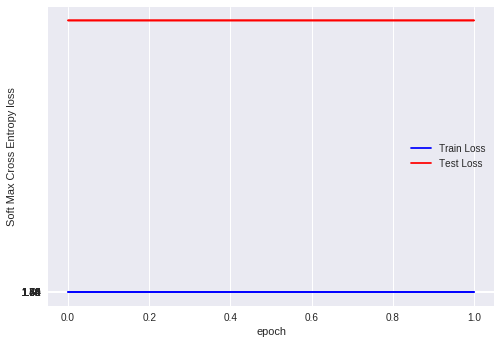

In [0]:
#source:appliedaicourse MLP assignmemnt
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
      train_avg_cost=0
      test_avg_cost=0
      total_batch=int(len(x_train)/batch_size)
      for ii in range(0,len(x_train),batch_size):
        batch_xs,batch_ys=x_train[ii:ii+batch_size],y_train[ii:ii+batch_size]
        
        #here we are using adam_optimiser
        _,c=sess.run([model['train_op'],model['cost'],],feed_dict={model['inputs']: batch_xs, model['labels']: batch_ys[:,None],model['keep_prob_']: 0.5})
        train_avg_cost+=c/total_batch
        
        for ee in range(0,len(x_test),batch_size):
          batch_xte,batch_yte=x_test[ee:ee+batch_size],y_test[ee:ee+batch_size]
          c=sess.run(model['cost'],feed_dict={model['inputs']:batch_xte,model['labels']:batch_yte[:,None],model['keep_prob_']:1.0})
          test_avg_cost+=c/total_batch
      xs.append(epoch)
      ytes.append(test_avg_cost)
      ytrs.append(train_avg_cost)
      plt_dynamic(xs,ytrs,ytes,ax,fig,np.arange(1.3,1.8,step=0.04))
      
      if epoch%display_step==0:
         print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    
    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,fig,np.arange(1.3, 1.8, step=0.04))
    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(model['predictions'],1), tf.argmax(model['labels'],1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({model['inputs']: x_test, model['labels']: y_test[:,None],model['keep_prob_']:1.0}))
    

In [0]:
len(xs)

NameError: ignored